# Fitting Anisotropic Power Diagrams to Grain Maps

In [1]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt

#from torchmin import minimize_torch as minimize_torch2

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### To check that the approach works, we will first create a small artificial 2D grain map using `PyAPD`:

Precision loss detected!
Percentage error =  170.40980529785156
Lloyds iteration: 0
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.765090823173523
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.5104020237922668
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7655006051063538
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7655006051063538
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7655006051063538
Lloyds iteration: 5
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7655006051063538
Lloyds iteration: 6
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.7655006051063538
Lloyds iteration: 7
Optimality condition successfully o

(<Figure size 756x756 with 1 Axes>, <Axes: >)

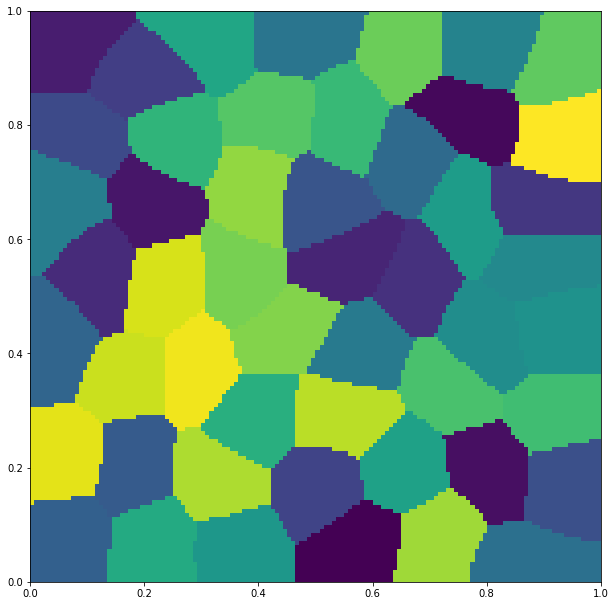

In [2]:
N = 50 # number of grains
apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = 2.0
)
apd1.check_optimality()
#apd1.find_optimal_W()
apd1.Lloyds_algorithm(K=10)
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

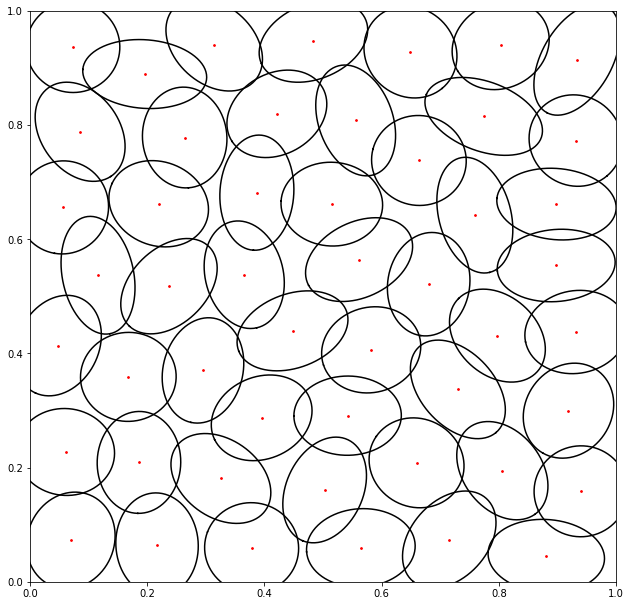

In [3]:
apd1.plot_ellipses()

In [4]:
# Save the data:
W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

# Save the grain map:
Y = copy.deepcopy(apd1.Y)
Y_t = Y.view(1, len(Y), 2)
II = copy.deepcopy(apd1.assemble_apd())
II = II + 1
y = LazyTensor(Y_t)
print("We have ", len(Y), " pixels and ", N, " grains.")

We have  19600  pixels and  50  grains.


## Reduced approach: fitting $W$

#### Equipped with the grain map, as a warm up let us try to use the approach to recover $W$. For this we do not need to rescale the variables, so we just proceed as follows:

In [5]:
eps = 1e-4 # regularisation parameter
gtol_scalar = 1e-3

In [15]:
def objective_function(X,A,W, use_torch = False, return_grad = False):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()
    
    W_t = W.view(dims[0],1,1)
    X_t = X.view(dims[0], 1, dims[1])
    second_sum = None
    second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',A,Y_t-X_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t-X_t)
        D_ij_torch = D_ij_torch = (D_ij_torch[:,:,None] - W_t)[:,:,0]
        second_sum = (-D_ij_torch/eps).logsumexp(dim=0).sum(dim=0)
        second_part_torch = (-D_ij_torch/eps).softmax(dim=0).sum(dim=1)/eps
    else:
        a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
        w = LazyTensor(W_t)
        x = LazyTensor(X_t)
        D_ij = ((y - x) | a.matvecmult(y - x)) - w
        second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    if return_grad:
        first_part = torch.bincount(II-1)/eps
        return -(first_sum - second_sum), -(first_part - second_part_torch)
    else:
        return -(first_sum - second_sum)

# Defining the convex function to be optmised:
fun_red = lambda W : objective_function(X_true,As_true, W)
fun_red_torch_grad = lambda W : objective_function(X_true,As_true, W, use_torch = True, return_grad = True)

In [32]:
W_true.requires_grad = True
W_true

tensor([-1.1121e-04, -7.8640e-04,  4.9429e-04, -6.4411e-04,  7.7580e-04,
        -6.1718e-04,  1.0155e-03, -4.7410e-05,  7.6983e-05,  1.0650e-03,
         1.5505e-04, -1.2282e-03,  1.2709e-03,  4.8025e-05, -5.5293e-06,
        -2.7551e-03,  8.8128e-04, -1.8267e-04, -1.5030e-04,  2.1989e-04,
         5.7129e-04,  8.2569e-04, -6.5766e-04, -3.8616e-04,  1.9613e-04,
         1.2706e-03,  1.8604e-04, -4.4167e-04, -6.9222e-04,  8.8050e-05,
        -9.0330e-04,  1.7394e-04,  5.6510e-05,  1.5091e-04, -7.5542e-04,
        -3.4360e-04,  6.4853e-04, -2.5877e-04, -1.6048e-03,  7.0310e-04,
         2.2045e-04,  9.3722e-04, -2.8292e-04, -1.1798e-04,  8.5572e-04,
         1.8472e-04,  3.6942e-04, -4.5037e-04, -3.7111e-04,  5.4588e-04],
       requires_grad=True)

In [33]:
f1 = fun_red(W_true)
f1

tensor([128.3750], grad_fn=<NegBackward0>)

In [34]:
d_f1 = torch.autograd.grad(f1, W_true, torch.ones_like(f1))[0]

In [35]:
d_f1

tensor([ -5253.7500, -18093.7500,   8901.5000,  22617.5000,  -3743.7500,
         -4777.0000, -15485.7500,  -2291.5000,  22630.2500,  12712.7500,
          2885.5000,   -808.7500,  -2574.5000,  13073.2500,  10292.5000,
          4672.5000,    637.0000,   2594.5000,    367.7500,   4172.5000,
         10185.2500,  13466.0000,  -8948.5000,   3513.2500,   4457.7500,
        -11891.2500,   9305.2500,  -1894.2500,  19096.5000,  -8824.7500,
        -17973.7500,   6742.2500, -12254.7500,  -4674.5000, -11445.7500,
         -7727.5000,   6419.2500,   4380.7500,   5315.5000,  -1882.2500,
        -10498.7500, -10770.5000,    -54.0000,  -3973.0000, -22594.7500,
         -1634.5000,  -9477.2500,   1825.2500,   -376.5000,   9662.0000])

In [36]:
f2, d_f2 = fun_red_torch_grad(W_true)

In [37]:
f2

tensor(128.3750, grad_fn=<NegBackward0>)

In [38]:
d_f2

tensor([ -5253.7500, -18093.2500,   8901.7500,  22617.5000,  -3743.7500,
         -4777.0000, -15485.7500,  -2291.5000,  22630.0000,  12713.0000,
          2885.7500,   -808.2500,  -2574.2500,  13073.0000,  10293.0000,
          4672.2500,    637.0000,   2594.7500,    368.2500,   4172.7500,
         10185.2500,  13465.7500,  -8948.2500,   3513.0000,   4457.7500,
        -11891.5000,   9305.0000,  -1894.5000,  19096.7500,  -8825.0000,
        -17973.7500,   6743.0000, -12254.5000,  -4674.5000, -11445.2500,
         -7727.7500,   6419.2500,   4380.5000,   5316.0000,  -1882.7500,
        -10498.5000, -10770.5000,    -54.2500,  -3972.2500, -22595.0000,
         -1634.7500,  -9477.5000,   1825.0000,   -376.2500,   9662.0000],
       grad_fn=<NegBackward0>)

In [39]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.7500, grad_fn=<MaxBackward1>)


In [40]:
gtol = gtol_scalar*torch.ones(N).to(device=device) # optimality condition (can be passed as vector!)

# solver = 'bfgs'
# defaultKwargs = {'gtol': gtol,
#                  'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':1000,
#                  'line_search': 'none',
#                  'lr': 1e-2,
#                 }

solver = 'newton-cg'
defaultKwargs = {#'gtol': gtol,
                 'xtol': 1e-6,
                 'disp': 3,
                 'max_iter':1000,
                 #'line_search': 'none',
                 #'lr': 1e-2,
                }

res = PyAPD.minimize_torch(fun_red, torch.zeros(N), method=solver,
                             options=defaultKwargs)

W_approx = res.x

initial fval: 3371.8750
iter   1 - fval: 501.6250
iter   2 - fval: 196.3125
iter   3 - fval: 146.5000
iter   4 - fval: 123.3125
iter   5 - fval: 121.5000
iter   6 - fval: 120.4375
iter   7 - fval: 120.3750
iter   8 - fval: 120.3125
iter   9 - fval: 120.1875
iter  10 - fval: 120.1875
Optimization terminated successfully.
         Current function value: 120.187500
         Iterations: 10
         Function evaluations: 24
         CG iterations: 28


In [41]:
res.grad

tensor([  25.2500,  -45.2500,  -18.0000,  -30.2500,   64.5000,    3.0000,
        -114.2500,   -4.0000,   81.7500,   26.7500,  -61.7500,  -32.0000,
         -12.5000,  -26.5000,  -45.5000,  -68.5000,  107.0000,  180.7500,
         -59.2500,   20.5000,   11.2500,  -21.7500,   53.7500,   64.7500,
         -27.7500,   26.0000,  -71.2500, -109.0000,  -36.2500,   80.0000,
        -169.2500,  -50.5000,  -57.7500,  -62.7500,   32.0000,   60.7500,
          25.2500,   -1.0000,  108.7500,   11.7500,   -6.2500,   33.0000,
          59.2500,    0.7500,   43.0000,   -9.7500,   51.0000,  -54.0000,
         -37.2500,   61.5000])

In [42]:
W_approx.requires_grad = True

In [43]:
print(fun_red(W_approx))
print(fun_red(W_true))

tensor([120.1875], grad_fn=<NegBackward0>)
tensor([128.3750], grad_fn=<NegBackward0>)


In [44]:
f1_approx = fun_red(W_approx)
f1_approx

tensor([120.1875], grad_fn=<NegBackward0>)

In [45]:
d_f1_approx = torch.autograd.grad(f1_approx, W_approx, torch.ones_like(f1_approx))[0]

In [46]:
d_f1_approx

tensor([  25.2500,  -45.2500,  -18.0000,  -30.2500,   64.5000,    3.0000,
        -114.2500,   -4.0000,   81.7500,   26.7500,  -61.7500,  -32.0000,
         -12.5000,  -26.5000,  -45.5000,  -68.5000,  107.0000,  180.7500,
         -59.2500,   20.5000,   11.2500,  -21.7500,   53.7500,   64.7500,
         -27.7500,   26.0000,  -71.2500, -109.0000,  -36.2500,   80.0000,
        -169.2500,  -50.5000,  -57.7500,  -62.7500,   32.0000,   60.7500,
          25.2500,   -1.0000,  108.7500,   11.7500,   -6.2500,   33.0000,
          59.2500,    0.7500,   43.0000,   -9.7500,   51.0000,  -54.0000,
         -37.2500,   61.5000])

In [47]:
f2_approx, d_f2_approx = fun_red_torch_grad(W_approx)

In [48]:
f2_approx

tensor(120.1875, grad_fn=<NegBackward0>)

In [49]:
d_f2_approx

tensor([  25.7500,  -45.0000,  -18.2500,  -30.7500,   64.7500,    2.7500,
        -114.2500,   -3.5000,   81.5000,   26.7500,  -61.0000,  -32.2500,
         -12.7500,  -26.7500,  -46.0000,  -68.2500,  107.2500,  180.7500,
         -59.5000,   20.7500,   11.0000,  -21.2500,   54.0000,   65.5000,
         -28.0000,   26.0000,  -71.2500, -109.2500,  -35.5000,   80.0000,
        -169.0000,  -50.2500,  -58.2500,  -63.0000,   32.5000,   60.7500,
          25.5000,   -1.0000,  108.7500,   12.5000,   -6.2500,   33.7500,
          59.2500,    0.5000,   43.2500,   -9.2500,   51.2500,  -54.2500,
         -37.2500,   62.0000], grad_fn=<NegBackward0>)

In [50]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.7500, grad_fn=<MaxBackward1>)


Number of misassigned pixels:  tensor(13)
Proportion of misassigned pixels:  tensor(0.0007)


Text(0.5, 1.0, 'Misalligned pixels')

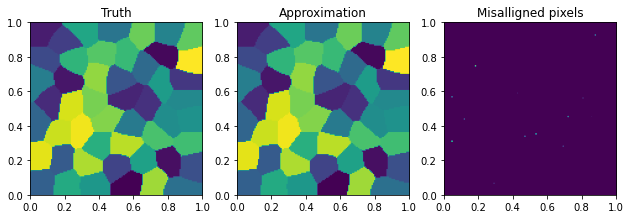

In [51]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

apd1.set_W(W = W_true) # reset weights to the optimum

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### All seems to work pretty well!

## Full approach: Fitting $X$, $\Lambda$ and $W$ at the same time

#### First let us try a naive approach where we do not worry too much about the matrices $\mathbf{A}_i$ being positive definite, but only with them being symmetric. That way each matrix only gives three variables $a_{i,11}$, $a_{i,22}$ and $a_{i,12}$. We thus have a flat variable
$$
\theta = \{(x_{i,1}, x_{i,2}, a_{i,11}, a_{i,22}, a_{i,12}, w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$
#### and e.g. we can assemble the optimum that we know:

In [6]:
theta_true = torch.cat((X_true[:,0],X_true[:,1],As_true[:,0,0],As_true[:,1,1],As_true[:,0,1],W_true))
theta_true

tensor([ 5.6456e-01,  7.7424e-01,  8.0607e-01,  2.1954e-01,  7.3332e-02,
         5.6153e-01,  1.1598e-01,  6.8032e-01,  8.9844e-01,  1.9566e-01,
         5.0277e-01,  8.5424e-02,  9.4013e-01,  5.1499e-01,  1.8584e-01,
         6.9570e-02,  4.7759e-02,  6.6366e-01,  8.8105e-01,  4.8361e-01,
         5.8222e-01,  5.5886e-02,  8.0319e-01,  8.9798e-01,  7.9763e-01,
         9.3196e-01,  3.7812e-01,  7.5913e-01,  6.5964e-01,  3.1428e-01,
         2.1671e-01,  3.9527e-01,  2.6389e-01,  5.5572e-01,  9.1895e-01,
         7.3014e-01,  4.2122e-01,  9.3324e-01,  6.4924e-01,  3.6551e-01,
         4.4792e-01,  3.8708e-01,  7.1546e-01,  3.2568e-01,  5.4196e-01,
         1.6769e-01,  2.3707e-01,  6.0568e-02,  2.9512e-01,  9.3123e-01,
         5.9463e-02,  8.1540e-01,  1.9469e-01,  6.6233e-01,  9.3693e-01,
         5.6447e-01,  5.3708e-01,  5.2140e-01,  6.6174e-01,  8.8956e-01,
         1.6090e-01,  7.8845e-01,  1.5856e-01,  6.6168e-01,  2.0918e-01,
         7.2504e-02,  4.1385e-01,  7.3815e-01,  4.5

#### We can also introduce the rescaled variables 
$$
\tilde \theta = \{(\tilde x_{i,1}, \tilde x_{i,2}, \tilde a_{i,11}, \tilde a_{i,22}, \tilde a_{i,12}, \tilde w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$

In [7]:
def rescaling(X, As, W):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

In [8]:
Xt_true, At_true, Wt_true = rescaling(X_true, As_true, W_true)
thetat_true = torch.cat((Xt_true[:,0],Xt_true[:,1],At_true[:,0,0],At_true[:,1,1],At_true[:,0,1],Wt_true))

#### And the new rescaled objective is

In [9]:
def objective_function_tilde(Xt,At,Wt, use_torch = False, return_grad = False):
    dims = At.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,II-1), Y)
    sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, II-1) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, II-1),Y)
    first_sum = (-sD_ij).sum()

    Wt_t = Wt.view(dims[0],1,1)
    Xt_t = Xt.view(dims[0], 1, dims[1])
    second_sum = None
    #second_part_torch = None
    if use_torch:
        MV_s = torch.einsum('bij,bkj->bki',At,Y_t)
        D_ij_torch = torch.einsum('bkj,bkj->bk',MV_s,Y_t)
        D_ij_torch = ((D_ij_torch[:,:,None] - Wt_t) - torch.einsum('ijk,lik->lji',Y_t,Xt_t))[:,:,0]
        second_sum = (-D_ij_torch).logsumexp(dim=0).sum(dim=0)
    else:
        at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
        wt = LazyTensor(Wt_t)
        xt = LazyTensor(Xt_t)
        D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
        second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
    return -(first_sum - second_sum)

#### We also want have the ability to go from flat variables to shaped variables quickly, so here are some helper functions:

In [10]:
def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [11]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W(thetat_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W(theta_true)
print(torch.dist(As_test,As_true))

tensor(2.1477e-07)
tensor(2.0618e-07)


In [12]:
# Defining the convex function to be optmised:
def fun(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [13]:
# Defining the convex function to be optmised:
def fun_torch(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt, use_torch=True)

In [16]:
# Sanity check
print(fun(thetat_true),fun_red(W_true))

tensor([128.4375]) tensor([128.3750])


In [17]:
thetat_true.requires_grad = True

In [18]:
f1 = fun(thetat_true)
f1

tensor([128.4375], grad_fn=<NegBackward0>)

In [19]:
d_f1 = torch.autograd.grad(f1, thetat_true, torch.ones_like(f1))[0]

In [20]:
d_f1

tensor([-2.2795e-01, -1.3795e+00,  7.7542e-01,  5.3042e-01, -5.5447e-03,
        -2.8073e-01, -2.1078e-01, -1.7130e-01,  1.8095e+00,  2.8934e-01,
         2.1207e-01, -2.5379e-02, -1.8921e-01,  6.4394e-01,  2.6338e-01,
         7.1110e-02, -2.3184e-02,  1.9351e-01,  9.3719e-02,  1.6629e-01,
         5.6107e-01,  1.1868e-01, -7.9587e-01,  3.4653e-01,  4.2480e-01,
        -1.0652e+00,  4.4705e-01, -2.3553e-01,  1.2189e+00, -2.3224e-01,
        -3.6812e-01,  2.0599e-01, -3.1757e-01, -1.7130e-01, -1.0307e+00,
        -6.4856e-01,  3.0116e-01,  3.7961e-01,  3.1952e-01, -2.3300e-02,
        -4.5392e-01, -5.4697e-01,  6.5399e-02, -2.4142e-01, -1.4736e+00,
         2.0981e-03, -2.6732e-01,  5.6900e-02,  2.3766e-02,  8.6026e-01,
        -5.5077e-02, -1.3724e+00,  2.3805e-01,  1.4146e+00, -3.0795e-01,
        -3.2271e-01, -9.9992e-01, -1.7139e-01,  1.5416e+00,  1.1252e+00,
         6.8657e-02,  1.6785e-02,  2.8965e-02,  9.4446e-01,  1.6003e-01,
         3.4193e-02, -3.8788e-02,  1.7819e-01,  3.1

In [21]:
f2 = fun_torch(thetat_true)
f2

tensor(128.4375, grad_fn=<NegBackward0>)

In [22]:
d_f2 = torch.autograd.grad(f2, thetat_true, torch.ones_like(f2))[0]

In [23]:
d_f2

tensor([-2.2800e-01, -1.3806e+00,  7.7496e-01,  5.3040e-01, -5.4398e-03,
        -2.8070e-01, -2.1080e-01, -1.7224e-01,  1.8113e+00,  2.8905e-01,
         2.1208e-01, -2.5509e-02, -1.8893e-01,  6.4426e-01,  2.6339e-01,
         7.1106e-02, -2.3176e-02,  1.9415e-01,  9.3781e-02,  1.6650e-01,
         5.6068e-01,  1.1873e-01, -7.9599e-01,  3.4668e-01,  4.2514e-01,
        -1.0656e+00,  4.4714e-01, -2.3569e-01,  1.2189e+00, -2.3218e-01,
        -3.6811e-01,  2.0596e-01, -3.1744e-01, -1.7194e-01, -1.0305e+00,
        -6.4761e-01,  3.0103e-01,  3.8000e-01,  3.2071e-01, -2.3376e-02,
        -4.5407e-01, -5.4741e-01,  6.5338e-02, -2.4139e-01, -1.4733e+00,
         2.0905e-03, -2.6736e-01,  5.6906e-02,  2.3735e-02,  8.5910e-01,
        -5.5088e-02, -1.3739e+00,  2.3791e-01,  1.4146e+00, -3.0722e-01,
        -3.2271e-01, -1.0001e+00, -1.7195e-01,  1.5430e+00,  1.1237e+00,
         6.8657e-02,  1.6174e-02,  2.9022e-02,  9.4495e-01,  1.6003e-01,
         3.4193e-02, -3.8727e-02,  1.7926e-01,  3.1

In [24]:
# check agreement between 
f12 = torch.abs(f1 - f2) # torch and keops for values
df12 = torch.abs(d_f1-d_f2).max() # autodiff torch vs keops
print(f12, df12)

tensor([0.0625], grad_fn=<AbsBackward0>) tensor(0.0006)


In [26]:
gtol = gtol_scalar*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-1.0))*torch.ones(N),((eps)**(-1.0))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

#thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
#                            torch.ones(N),torch.ones(N), torch.zeros(N),
#                            torch.zeros(N)))

fun(thetat_initial)

tensor([1.7270e+08])

In [58]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0.0, 'disp': 2, 'max_iter':10000}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':1000,
                 'line_search': 'none',
                 #'lr': 1e-1,
                }

# solver = 'newton-cg'
# defaultKwargs = {#'gtol': gtol,
#                  #'xtol': -1e-10,
#                  'disp': 3,
#                  'max_iter':500,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

# solver='cg'
# defaultKwargs = {'gtol': 1e-3,
#                  #'xtol': 1e-10,
#                  'disp': 3,
#                  'max_iter':1000,
#                  #'line_search': 'none',
#                  #'lr': 1e-2,
#                 }

res = PyAPD.minimize_torch(fun_torch, thetat_initial, method=solver,
                             options=defaultKwargs)

thetat_approx = res.x

Optimality condition successfully overwritten.
initial fval: 172704784.0000
iter   1 - fval: 172699744.0000
iter   2 - fval: 146683344.0000
iter   3 - fval: 133981648.0000
iter   4 - fval: 121476056.0000
iter   5 - fval: 114562176.0000
iter   6 - fval: 104186928.0000
iter   7 - fval: 95501632.0000
iter   8 - fval: 93364680.0000
iter   9 - fval: 88035264.0000
iter  10 - fval: 85148640.0000
iter  11 - fval: 78515296.0000
iter  12 - fval: 68192800.0000
iter  13 - fval: 61265976.0000
iter  14 - fval: 58814744.0000
iter  15 - fval: 51034464.0000
iter  16 - fval: 48627584.0000
iter  17 - fval: 45389888.0000
iter  18 - fval: 40374952.0000
iter  19 - fval: 35709528.0000
iter  20 - fval: 35642976.0000
iter  21 - fval: 35876544.0000
iter  22 - fval: 30697968.0000
iter  23 - fval: 32365208.0000
iter  24 - fval: 29107880.0000
iter  25 - fval: 27273048.0000
iter  26 - fval: 24782080.0000
iter  27 - fval: 22384744.0000
iter  28 - fval: 21145112.0000
iter  29 - fval: 23064464.0000
iter  30 - fval: 19

In [59]:
res.grad

tensor([-8.4076e-03, -1.8463e-02, -3.4515e-02,  1.3908e-02,  1.2938e-02,
        -1.9699e-02, -1.6670e-03, -9.0332e-03,  4.1840e-02, -7.9727e-03,
        -1.1627e-02,  1.0036e-02, -5.4932e-03,  1.1826e-02,  4.6730e-02,
        -8.5163e-03,  2.7168e-02, -1.0742e-02, -1.5472e-02,  1.1658e-02,
        -2.4887e-02, -2.5520e-03,  2.8961e-02, -5.4474e-02, -8.1787e-03,
        -2.1606e-02,  2.8244e-02,  6.3263e-02,  1.3733e-04, -1.2993e-02,
        -3.8765e-02, -1.8951e-02,  4.2114e-03,  2.7420e-02,  2.2675e-02,
        -1.5137e-02,  1.9073e-02,  1.7120e-02, -2.4261e-02,  5.0964e-03,
         5.3131e-02,  1.0635e-02, -3.0884e-02, -5.2422e-02,  3.4576e-02,
        -9.4757e-03, -1.0818e-02, -2.1189e-02,  6.7902e-04,  1.4923e-02,
        -1.8633e-02, -3.8910e-02,  1.3382e-02,  3.0396e-02, -3.8788e-02,
        -4.9362e-02, -1.4679e-02,  1.4648e-02,  9.5215e-03,  1.7883e-02,
         7.0877e-03,  1.5961e-02,  1.6048e-02, -2.4933e-02, -3.9993e-02,
        -4.5317e-02,  2.3880e-02, -8.5449e-03, -6.6

In [60]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [61]:
thetat_approx.requires_grad = True

In [62]:
print(fun(thetat_approx))
print(fun(thetat_true))

tensor([816.], grad_fn=<NegBackward0>)
tensor([128.4375], grad_fn=<NegBackward0>)


In [63]:
f1_approx = fun(thetat_approx)
f1_approx

tensor([816.], grad_fn=<NegBackward0>)

In [64]:
d_f1_approx = torch.autograd.grad(f1_approx, thetat_approx, torch.ones_like(f1_approx))[0]

In [65]:
d_f1_approx

tensor([-8.5297e-03, -1.8372e-02, -3.5461e-02,  1.3115e-02,  1.3039e-02,
        -1.9989e-02, -1.4801e-03, -9.2163e-03,  4.3121e-02, -8.2169e-03,
        -1.1368e-02,  9.9411e-03, -6.7444e-03,  1.0742e-02,  4.6852e-02,
        -8.4820e-03,  2.7193e-02, -1.1353e-02, -1.5869e-02,  1.1307e-02,
        -2.5681e-02, -2.7466e-03,  2.7405e-02, -5.5573e-02, -7.9346e-03,
        -2.2095e-02,  2.8061e-02,  6.2958e-02,  9.7656e-04, -1.3100e-02,
        -3.9001e-02, -1.8845e-02,  3.8757e-03,  2.7390e-02,  2.2766e-02,
        -1.5533e-02,  1.9302e-02,  1.9257e-02, -2.4246e-02,  5.5084e-03,
         5.2444e-02,  9.9030e-03, -3.2318e-02, -5.2895e-02,  3.4622e-02,
        -9.9335e-03, -1.1093e-02, -2.1301e-02,  1.9836e-04,  1.3062e-02,
        -1.8570e-02, -3.9215e-02,  1.3100e-02,  2.8473e-02, -3.7720e-02,
        -4.9606e-02, -1.4465e-02,  1.4587e-02,  1.0559e-02,  1.6388e-02,
         7.1259e-03,  1.5869e-02,  1.5766e-02, -2.6031e-02, -3.9909e-02,
        -4.5277e-02,  2.4002e-02, -9.1553e-03, -6.6

In [66]:
f2_approx = fun_torch(thetat_approx)
f2_approx

tensor(816., grad_fn=<NegBackward0>)

In [67]:
d_f2_approx = torch.autograd.grad(f2_approx, thetat_approx, torch.ones_like(f2_approx))[0]

In [68]:
d_f2_approx

tensor([-8.4076e-03, -1.8463e-02, -3.4515e-02,  1.3908e-02,  1.2938e-02,
        -1.9699e-02, -1.6670e-03, -9.0332e-03,  4.1840e-02, -7.9727e-03,
        -1.1627e-02,  1.0036e-02, -5.4932e-03,  1.1826e-02,  4.6730e-02,
        -8.5163e-03,  2.7168e-02, -1.0742e-02, -1.5472e-02,  1.1658e-02,
        -2.4887e-02, -2.5520e-03,  2.8961e-02, -5.4474e-02, -8.1787e-03,
        -2.1606e-02,  2.8244e-02,  6.3263e-02,  1.3733e-04, -1.2993e-02,
        -3.8765e-02, -1.8951e-02,  4.2114e-03,  2.7420e-02,  2.2675e-02,
        -1.5137e-02,  1.9073e-02,  1.7120e-02, -2.4261e-02,  5.0964e-03,
         5.3131e-02,  1.0635e-02, -3.0884e-02, -5.2422e-02,  3.4576e-02,
        -9.4757e-03, -1.0818e-02, -2.1189e-02,  6.7902e-04,  1.4923e-02,
        -1.8633e-02, -3.8910e-02,  1.3382e-02,  3.0396e-02, -3.8788e-02,
        -4.9362e-02, -1.4679e-02,  1.4648e-02,  9.5215e-03,  1.7883e-02,
         7.0877e-03,  1.5961e-02,  1.6048e-02, -2.4933e-02, -3.9993e-02,
        -4.5317e-02,  2.3880e-02, -8.5449e-03, -6.6

In [69]:
# check agreement between 
f12 = torch.abs(f1_approx - f2_approx) # torch and keops for values
df12 = torch.abs(d_f1_approx-d_f2_approx).max() # manual torch gradients and autodiff keops
print(f12, df12)

tensor([0.], grad_fn=<AbsBackward0>) tensor(0.0038)


In [70]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(253)
Proportion of misassigned pixels:  tensor(0.0129)


Text(0.5, 1.0, 'Misalligned pixels')

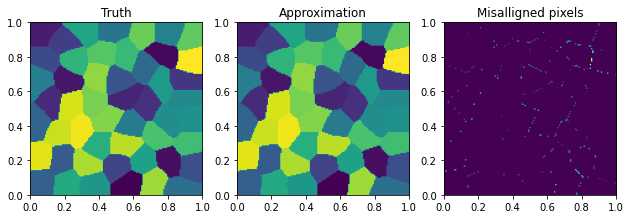

In [71]:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

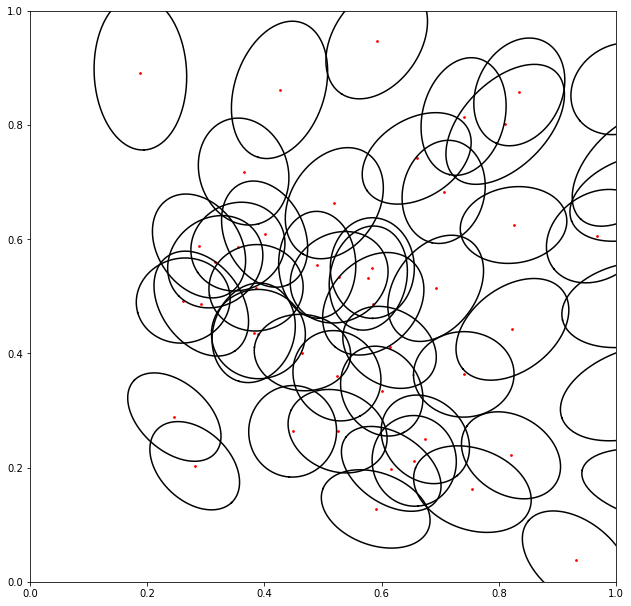

In [57]:
apd2.plot_ellipses()

In [42]:
torch.linalg.det(apd2.As)

tensor([1.2674, 0.5426, 1.1980, 1.0711, 0.5168, 1.2206, 1.0049, 0.8521, 0.7593,
        0.8467, 1.2570, 0.9164, 0.5441, 1.0480, 1.0070, 1.6416, 1.1687, 1.1402,
        0.9581, 0.6768, 1.3118, 0.9872, 0.7703, 0.8338, 0.7749, 0.6204, 0.9431,
        1.0115, 1.2415, 0.5405, 1.1957, 1.1929, 1.0358, 0.8765, 0.6493, 0.8935,
        0.7179, 0.9495, 0.9269, 0.8815, 0.8961, 1.0628, 0.8101, 1.0822, 1.4153,
        1.0124, 1.1311, 1.2941, 1.2737, 0.6546])

#### Not caring about positive definiteness of the matrices seems to affect things, which can be seen e.g. by restarting the optimisation procedure at a better initial guess:

In [185]:
print("The found optimum: ", fun(res.x))
print("The known actually optimum: ", fun(thetat_true))

The found optimum:  tensor([35.])
The known actually optimum:  tensor([41.])


In [188]:
res2 = PyAPD.minimize_torch(fun, thetat_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 41.0000
iter   1 - fval: 40.8984
iter   2 - fval: 40.6250
iter   3 - fval: 40.3516
iter   4 - fval: 40.1094
iter   5 - fval: 39.8984
iter   6 - fval: 39.6875
iter   7 - fval: 39.5156
iter   8 - fval: 39.3594
iter   9 - fval: 39.2266
iter  10 - fval: 39.0938
iter  11 - fval: 38.9766
iter  12 - fval: 38.8672
iter  13 - fval: 38.7656
iter  14 - fval: 38.6719
iter  15 - fval: 38.6016
iter  16 - fval: 38.4922
iter  17 - fval: 38.4219
iter  18 - fval: 38.3438
iter  19 - fval: 38.2500
iter  20 - fval: 38.1875
iter  21 - fval: 38.1094
iter  22 - fval: 38.0391
iter  23 - fval: 37.9531
iter  24 - fval: 37.8906
iter  25 - fval: 37.8125
iter  26 - fval: 37.7344
iter  27 - fval: 37.6562
iter  28 - fval: 37.5625
iter  29 - fval: 37.5156
iter  30 - fval: 37.4375
iter  31 - fval: 37.3750
iter  32 - fval: 37.3047
iter  33 - fval: 37.2578
iter  34 - fval: 37.1953
iter  35 - fval: 37.1328
iter  36 - fval: 37.0859
iter  37 - fval: 37.0391
iter  

In [189]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [191]:
torch.linalg.det(As_approx)

tensor([-0.0224,  0.6182, -0.0626,  0.0627, -0.2718,  0.3047,  0.2299, -0.3152,
        -0.6137,  0.0820])

In [192]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(), As = As_approx.contiguous(), W = W_approx2.contiguous())

Number of misassigned pixels:  tensor(14)
Proportion of misassigned pixels:  tensor(0.0036)


Text(0.5, 1.0, 'Misalligned pixels')

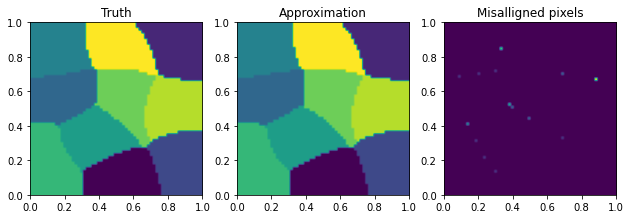

In [193]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### Another issues worth thinking about is the interplay and redundancies with respect to $X$, $\Lambda$ and $W$, e.g. the determinant of matrices, the shifting of weights by a constant etc.

## Cholesky decomposition approach

In [194]:
def As_from_cholesky(l11,l22,l12):
    L = torch.stack([torch.stack([l11, l12],dim=1),
                            torch.stack([torch.zeros(len(l11)), l22], dim=1)],dim=2)
    return L @ torch.transpose(L,1,2)

In [195]:
def from_theta_to_X_A_W_cholesky(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    l22 = theta[(3*N):(4*N)]
    l12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [196]:
Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_true = torch.cat((X_true[:,0],X_true[:,1],Ls_true[:,0,0],Ls_true[:,1,1],Ls_true[:,1,0],W_true))
theta_cholesky_true.shape

torch.Size([60])

In [197]:
Lt_true = Ls_true/(eps**(0.5))

thetat_cholesky_true = torch.cat((Xt_true[:,0],Xt_true[:,1],Lt_true[:,0,0],Lt_true[:,1,1], Lt_true[:,1,0],Wt_true))
thetat_cholesky_true.shape

torch.Size([60])

In [198]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky(thetat_cholesky_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky(theta_cholesky_true)
print(torch.dist(As_test,As_true))

tensor(9.0205e-07)
tensor(3.5075e-07)


In [199]:
# Defining the convex function to be optmised:
def fun_cholesky(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [200]:
# Sanity check
print(fun(thetat_true), fun_cholesky(thetat_cholesky_true),fun_red(W_true))

tensor([41.]) tensor([41.0078]) tensor([41.0078])


In [201]:
gtol = gtol_scalar*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.25))*torch.ones(N),((eps)**(-0.25))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky(thetat_cholesky_initial)

tensor([2462149.])

In [216]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':6000,
                 'line_search': 'none',
                 'lr': 1e-1,
                }

res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 2462149.0000
iter   1 - fval: 2461677.0000
iter   2 - fval: 420809792.0000
iter   3 - fval: 343552448.0000
iter   4 - fval: 278460992.0000
iter   5 - fval: 225257776.0000
iter   6 - fval: 159668320.0000
iter   7 - fval: 109718728.0000
iter   8 - fval: 76695840.0000
iter   9 - fval: 45321636.0000
iter  10 - fval: 22578788.0000
iter  11 - fval: 18540828.0000
iter  12 - fval: 15636382.0000
iter  13 - fval: 11498106.0000
iter  14 - fval: 8827852.0000
iter  15 - fval: 7639919.0000
iter  16 - fval: 6963091.0000
iter  17 - fval: 5680813.5000
iter  18 - fval: 3607037.5000
iter  19 - fval: 3011329.0000
iter  20 - fval: 2158532.2500
iter  21 - fval: 2011750.5000
iter  22 - fval: 1411610.1250
iter  23 - fval: 1049137.2500
iter  24 - fval: 855810.7500
iter  25 - fval: 813480.6250
iter  26 - fval: 776158.5000
iter  27 - fval: 705225.1250
iter  28 - fval: 660812.1250
iter  29 - fval: 620553.7500
iter  30 - fval: 583907.8750
iter  31 - fval

In [217]:
res.grad

tensor([ 2.7252e-02, -2.4069e-01, -9.1461e-02,  1.1055e-01, -3.8387e-02,
        -5.0369e-02, -3.0518e-03,  2.6796e-01, -3.4869e-01,  3.6774e-01,
         1.3455e-01, -1.6711e-01, -2.7382e-02,  1.3506e-01,  1.4252e-02,
        -1.1041e-01, -7.8331e-02,  2.4713e-01, -3.1163e-01,  1.6418e-01,
         1.8050e+00, -2.3307e+01, -8.4174e+00,  2.7148e+00,  1.8591e-01,
         5.5599e-01, -1.1390e+00, -2.1068e+01,  1.7475e+01,  4.6586e+01,
         1.7827e+00, -3.7512e+01,  2.6151e-02, -1.6875e+00, -4.8612e-01,
        -5.4679e+00,  2.2726e+00, -1.7515e+01, -2.6158e+01,  1.3160e+01,
         1.2585e+00, -3.1064e+01, -1.4971e+00,  9.3072e+00, -2.5720e+00,
        -4.0469e+00, -1.8468e+00, -1.1900e+01,  1.3383e+01,  5.9276e+01,
        -8.0780e-02, -2.0862e-01,  3.5614e-02,  3.7671e-01, -2.8015e-02,
         1.5009e-01, -1.5601e-01,  4.6985e-01, -7.5287e-01,  1.9391e-01])

In [218]:
Xt_approx3, At_approx3, Wt_approx3 = from_theta_to_X_A_W_cholesky(res.x)
X_approx3, As_approx3, W_approx3 = inverse_rescaling(Xt_approx3, At_approx3, Wt_approx3)

In [219]:
torch.linalg.det(As_approx3)

tensor([ 7.4797,  2.1379,  0.3585,  0.2007,  0.2439,  4.6586, 12.5315,  6.0207,
         9.8411,  0.0867])

In [220]:
apd3 = PyAPD.apd_system(X = X_approx3.contiguous(), As = As_approx3.contiguous(), W = W_approx3.contiguous())

Number of misassigned pixels:  tensor(72)
Proportion of misassigned pixels:  tensor(0.0187)


Text(0.5, 1.0, 'Misalligned pixels')

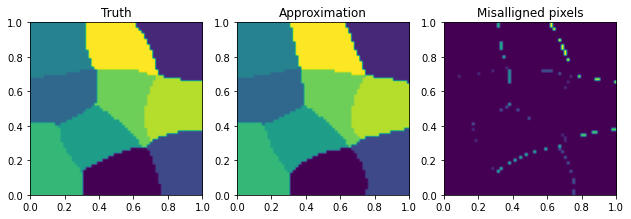

In [221]:
img_approx3 = copy.deepcopy(apd3.assemble_apd())

difff = sum(torch.abs(img_true - img_approx3) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx3.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx3).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

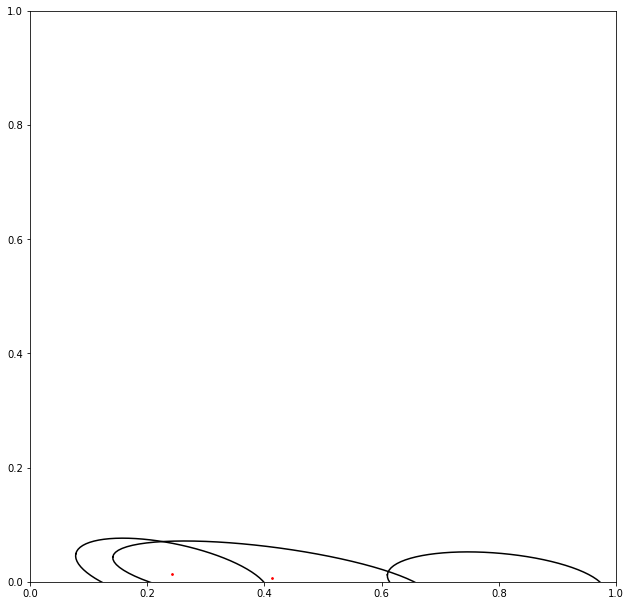

In [215]:
apd3.plot_ellipses()

In [222]:
res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 41.0078
iter   1 - fval: 41.5625
iter   2 - fval: 41.2344
iter   3 - fval: 40.9609
iter   4 - fval: 40.6953
iter   5 - fval: 40.4609
iter   6 - fval: 40.2578
iter   7 - fval: 40.1172
iter   8 - fval: 39.9609
iter   9 - fval: 39.8281
iter  10 - fval: 39.7188
iter  11 - fval: 39.6094
iter  12 - fval: 39.5234
iter  13 - fval: 39.4453
iter  14 - fval: 39.3672
iter  15 - fval: 39.2969
iter  16 - fval: 39.2500
iter  17 - fval: 39.1875
iter  18 - fval: 39.1406
iter  19 - fval: 39.0938
iter  20 - fval: 39.0312
iter  21 - fval: 39.0000
iter  22 - fval: 38.9453
iter  23 - fval: 38.9062
iter  24 - fval: 38.8750
iter  25 - fval: 38.8281
iter  26 - fval: 38.8047
iter  27 - fval: 38.7656
iter  28 - fval: 38.7266
iter  29 - fval: 38.6953
iter  30 - fval: 38.6641
iter  31 - fval: 38.6328
iter  32 - fval: 38.6016
iter  33 - fval: 38.5703
iter  34 - fval: 38.5391
iter  35 - fval: 38.5000
iter  36 - fval: 38.4766
iter  37 - fval: 38.4453
iter  

KeyboardInterrupt: 

## Keeping determinant fixed

In [42]:
def from_theta_to_X_A_W_cholesky_red(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    #l22 = theta[(3*N):(4*N)]
    l22 = 1.0/(eps*l11)
    l12 = theta[(3*N):(4*N)]
    Wt = theta[(4*N):(5*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [43]:
#Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_red_true = torch.cat((X_true[:,0],X_true[:,1],Ls_true[:,0,0],Ls_true[:,1,0],W_true))
theta_cholesky_red_true.shape

torch.Size([50])

In [44]:
thetat_cholesky_red_true = torch.cat((Xt_true[:,0],Xt_true[:,1],Lt_true[:,0,0],Lt_true[:,1,0],Wt_true))
thetat_cholesky_red_true.shape

torch.Size([50])

In [45]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky_red(theta_cholesky_red_true)
print(torch.dist(As_test,As_true)) # that's fine for now

tensor(8.7692e-07)
tensor(3516854.5000)


In [46]:
# Defining the convex function to be optmised:
def fun_cholesky_red(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky_red(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [47]:
# Sanity check
print(fun(thetat_true), fun_cholesky(thetat_cholesky_true),fun_cholesky_red(thetat_cholesky_red_true))

tensor([41.]) tensor([41.0078]) tensor([41.0078])


In [48]:
gtol = gtol_scalar*torch.ones(5*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_red_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.5))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky_red(thetat_cholesky_red_initial)

tensor([2252026.5000])

In [49]:
_, At_initial_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_initial)
torch.linalg.det(At_initial_test)

tensor([999999.7500, 999999.7500, 999999.7500, 999999.7500, 999999.7500,
        999999.7500, 999999.7500, 999999.7500, 999999.7500, 999999.7500])

In [50]:
At_initial_test[0]

tensor([[999.9999,   0.0000],
        [  0.0000, 999.9998]])

In [51]:
solver = 'bfgs'
defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 2252026.5000
iter   1 - fval: 1007122.0000
iter   2 - fval: 826561.5000
iter   3 - fval: 635052.8750
iter   4 - fval: 377081.0000
iter   5 - fval: 232903.7500
iter   6 - fval: 176139.8750
iter   7 - fval: 152918.3750
iter   8 - fval: 109776.0000
iter   9 - fval: 98018.0000
iter  10 - fval: 90648.7500
iter  11 - fval: 89127.1250
iter  12 - fval: 87193.7500
iter  13 - fval: 85203.8750
iter  14 - fval: 82315.7500
iter  15 - fval: 80100.1250
iter  16 - fval: 78348.6250
iter  17 - fval: 76958.7500
iter  18 - fval: 75392.3750
iter  19 - fval: 74264.0000
iter  20 - fval: 72992.5000
iter  21 - fval: 72577.1250
iter  22 - fval: 71264.3750
iter  23 - fval: 70636.3750
iter  24 - fval: 70013.0000
iter  25 - fval: 69149.7500
iter  26 - fval: 68229.8750
iter  27 - fval: 66367.8750
iter  28 - fval: 64897.5000
iter  29 - fval: 63272.3750
iter  30 - fval: 61820.6250
iter  31 - fval: 60514.5000
iter  32 - fval: 58784.0000
iter  33 - fval: 5787

In [52]:
Xt_approx4, At_approx4, Wt_approx4 = from_theta_to_X_A_W_cholesky_red(res.x)
X_approx4, As_approx4, W_approx4 = inverse_rescaling(Xt_approx4, At_approx4, Wt_approx4)

In [53]:
torch.linalg.det(As_approx4)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [54]:
apd4 = PyAPD.apd_system(X = X_approx4.contiguous(), As = As_approx4.contiguous(), W = W_approx4.contiguous())

Number of misassigned pixels:  tensor(347)
Proportion of misassigned pixels:  tensor(0.0903)


Text(0.5, 1.0, 'Misalligned pixels')

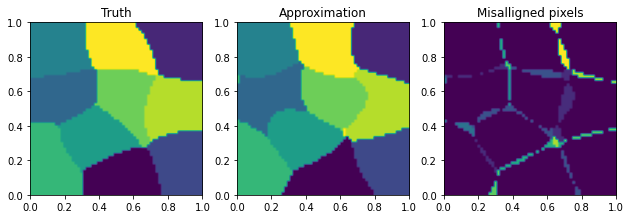

In [55]:
img_approx4 = copy.deepcopy(apd4.assemble_apd())

difff = sum(torch.abs(img_true - img_approx4) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx4.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx4).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

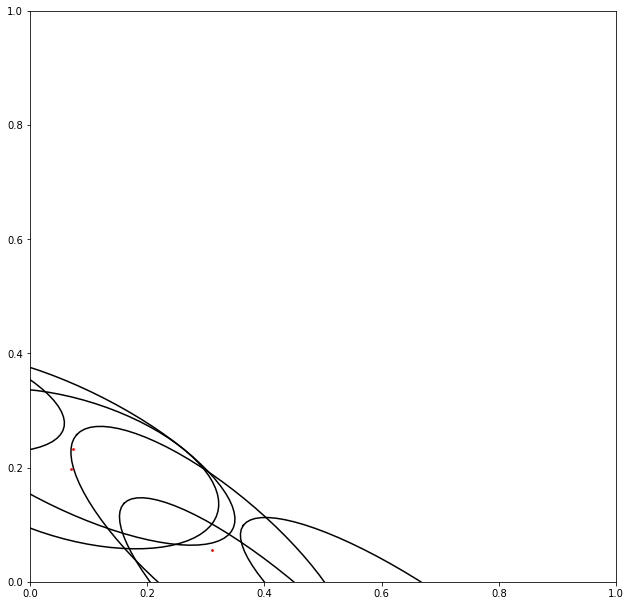

In [56]:
apd4.plot_ellipses()

In [57]:
res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 41.0078
iter   1 - fval: 40.1641
iter   2 - fval: 39.5156
iter   3 - fval: 39.3203
iter   4 - fval: 38.9219
iter   5 - fval: 38.8359
iter   6 - fval: 38.7891
iter   7 - fval: 38.7344
iter   8 - fval: 38.6797
iter   9 - fval: 38.6094
iter  10 - fval: 38.5234
iter  11 - fval: 38.4453
iter  12 - fval: 38.3672
iter  13 - fval: 38.2969
iter  14 - fval: 38.1953
iter  15 - fval: 38.0625
iter  16 - fval: 37.9297
iter  17 - fval: 37.8672
iter  18 - fval: 37.8438
iter  19 - fval: 37.8281
iter  20 - fval: 37.8125
iter  21 - fval: 37.7969
iter  22 - fval: 37.7734
iter  23 - fval: 37.7656
iter  24 - fval: 37.7500
iter  25 - fval: 37.7500
Optimization terminated successfully.
         Current function value: 37.750000
         Iterations: 25
         Function evaluations: 27


In [102]:
import numpy as np

In [104]:
np.exp(-1/eps)

0.0